Importing libaries 

In [2106]:
import pandas as pd
import datetime as dt
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2107]:
pd.set_option("display.max_rows", 30, "display.max_columns", None)

# IMPORT AND CLEANING

We import that dataframe and remove 2020-10 to 2021-04 since we are missing some values, and this data is during Covid so to avoid that skew we removed the data

In [2108]:
df = pd.read_csv(Path('Resources\DataforMLtesting.csv'))
df = df[~df['REF_DATE'].isin(['2020-10', '2021-01', '2021-04'])]
df.head()

,Unnamed: 0,REF_DATE,GEO,DGUID,National Occupational Classification,Job vacancy characteristics,Statistics,VALUE,STATUS
0,1233457,2015-04,Newfoundland and Labrador,2016A000210,"Business, finance and administration occupatio...",Full-time,Job vacancies,430.0,D
1,1242071,2015-04,Newfoundland and Labrador,2016A000210,Natural and applied sciences and related occup...,Full-time,Job vacancies,170.0,D
2,1251511,2015-04,Newfoundland and Labrador,2016A000210,Health occupations [3],Full-time,Job vacancies,265.0,D
3,1251514,2015-04,Newfoundland and Labrador,2016A000210,Health occupations [3],Part-time,Job vacancies,260.0,D
4,1257411,2015-04,Newfoundland and Labrador,2016A000210,"Occupations in education, law and social, comm...",Full-time,Job vacancies,130.0,D


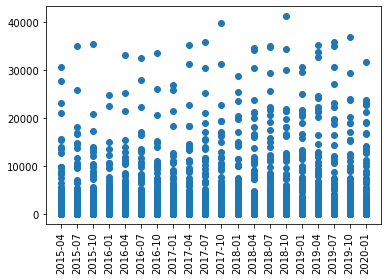

In [2109]:
plt.scatter(df.REF_DATE, df.VALUE)
plt.xticks(rotation = 90)
plt.show()

Dropping uneeded columns for encoding, and renaming column names for easier access

In [2110]:
df.columns
df = df.drop(["Unnamed: 0","DGUID","Statistics","STATUS"],axis=1)
df.columns.values[2] = "NOC"
df.columns.values[3] = "JOB_CHAR"


In [2111]:
df.iloc[:,1:4]

,GEO,NOC,JOB_CHAR
0,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time
1,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time
2,Newfoundland and Labrador,Health occupations [3],Full-time
3,Newfoundland and Labrador,Health occupations [3],Part-time
4,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time
...,...,...,...
2961,Nunavut,"Business, finance and administration occupatio...",Full-time
2962,Nunavut,Natural and applied sciences and related occup...,Full-time
2963,Nunavut,Natural and applied sciences and related occup...,Part-time
2964,Nunavut,"Trades, transport and equipment operators and ...",Full-time


Encoding Quarters by labels since orignally it is 1 4 7 10, we transform this to 1 2 3 4 Quarters, we also convert Year to INT and drop REF DATE, Formating and sorting as well

In [2112]:
LE= LabelEncoder()
df[['YEAR', 'QUARTER']] = df['REF_DATE'].str.split('-', 1, expand=True)
df["QUARTER"]=LE.fit_transform(df["QUARTER"])
df["QUARTER"] += 1
df["YEAR"] = df["YEAR"].astype(int)
# df["QUARTER"] = df["QUARTER"].astype(int)
df = df.drop(columns=["REF_DATE"])


In [2113]:
df.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df


,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE
0,2015,2,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,430.0
1,2015,2,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170.0
2,2015,2,Newfoundland and Labrador,Health occupations [3],Full-time,265.0
3,2015,2,Newfoundland and Labrador,Health occupations [3],Part-time,260.0
4,2015,2,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130.0
...,...,...,...,...,...,...
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0
2963,2020,1,Nunavut,Natural and applied sciences and related occup...,Part-time,0.0
2964,2020,1,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85.0


In [2114]:
df["QUARTER"].unique()

array([2, 3, 4, 1])

Creating a function to grab previous job vacancy and return np.nan if it does not exist

In [2115]:
def prevVacancies(row):

    # There is no previous data for 2015 Quarter 2, therefor it is automatically np.nan
    if (row["YEAR"] == 2015) & (row["QUARTER"] == 2):
        return np.nan

        # If Quarter is 1 then return the previous years Quarter 4 vacancy value IF it exists, if it does not return np.nan 
    elif (row["QUARTER"] == 1): 
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]
            
    else:
        # Returns the previous Quarters value if it is not empty, if it is empty returns np.nan
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]



In [2116]:
df["PREVIOUS_VACANCY"] = df.apply(prevVacancies, axis=1)
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
0,2015,2,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,430.0,NaN
1,2015,2,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170.0,NaN
2,2015,2,Newfoundland and Labrador,Health occupations [3],Full-time,265.0,NaN
3,2015,2,Newfoundland and Labrador,Health occupations [3],Part-time,260.0,NaN
4,2015,2,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130.0,NaN
...,...,...,...,...,...,...,...
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0,45.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0,50.0
2963,2020,1,Nunavut,Natural and applied sciences and related occup...,Part-time,0.0,NaN
2964,2020,1,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85.0,40.0


In [2117]:
TestNOC = "Health occupations [3]"

print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == TestNOC) & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )
print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2019) & (df["QUARTER"] == 4) & (df["NOC"] == TestNOC) & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )


840.0
690.0


In [2118]:
df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == TestNOC) & (df["JOB_CHAR"] == "Full-time")]

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
2929,2020,1,Alberta,Health occupations [3],Full-time,840.0,690.0


Removing rows that do not have previous Vacancy value, only a loss of 2966 -> 2456 rows 

In [2119]:
df = df[df.PREVIOUS_VACANCY.notna()]
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
133,2015,3,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,330.0,430.0
134,2015,3,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,225.0,170.0
135,2015,3,Newfoundland and Labrador,Health occupations [3],Full-time,315.0,265.0
136,2015,3,Newfoundland and Labrador,Health occupations [3],Part-time,350.0,260.0
137,2015,3,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,260.0,130.0
...,...,...,...,...,...,...,...
2959,2020,1,Yukon,"Trades, transport and equipment operators and ...",Full-time,60.0,35.0
2960,2020,1,Nunavut,Management occupations [0],Full-time,65.0,35.0
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0,45.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0,50.0


# ENCODING 

Here we do label encoding on columns GEO, NOC, JOB_CHAR then we do OneHotEncoding on each of the columns and merge them and remove the original column. Also reset the index since we removed rows, the index numbers will not match and when we merge we will lose data going to 2002 rows. 

In [2120]:
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
133,2015,3,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,330.0,430.0
134,2015,3,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,225.0,170.0
135,2015,3,Newfoundland and Labrador,Health occupations [3],Full-time,315.0,265.0
136,2015,3,Newfoundland and Labrador,Health occupations [3],Part-time,350.0,260.0
137,2015,3,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,260.0,130.0
...,...,...,...,...,...,...,...
2959,2020,1,Yukon,"Trades, transport and equipment operators and ...",Full-time,60.0,35.0
2960,2020,1,Nunavut,Management occupations [0],Full-time,65.0,35.0
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0,45.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0,50.0


In [2121]:
for column in df.iloc[:,2:5]:
    df[column]=LE.fit_transform(df[column])
df.reset_index(inplace = True, drop=True)
df["GEO"].unique()

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([ 4,  9,  6,  3, 10,  8,  2, 11,  0,  1, 12,  7,  5])

In [2122]:
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(df.GEO.values.reshape(-1,1)))
encode_df.columns = enc.get_feature_names(['PROVINCE'])
encode_df

,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [2123]:
encode_df2 = pd.DataFrame(enc.fit_transform(df.NOC.values.reshape(-1,1)))
encode_df2.columns = enc.get_feature_names(['NOC'])
encode_df2

,NOC_0,NOC_1,NOC_2,NOC_3,NOC_4,NOC_5,NOC_6,NOC_7,NOC_8,NOC_9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2452,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2454,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2124]:
encode_df3 = pd.DataFrame(enc.fit_transform(df.JOB_CHAR.values.reshape(-1,1)))
encode_df3.columns = enc.get_feature_names(['JOB_CHAR'])
encode_df3

,JOB_CHAR_0,JOB_CHAR_1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0
...,...,...
2451,1.0,0.0
2452,1.0,0.0
2453,1.0,0.0
2454,1.0,0.0


In [2125]:
df = df.merge(encode_df,left_index=True,right_index=True).drop("GEO",1)
df = df.merge(encode_df2,left_index=True,right_index=True).drop("NOC",1)
df = df.merge(encode_df3,left_index=True,right_index=True).drop("JOB_CHAR",1)
df

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,YEAR,QUARTER,VALUE,PREVIOUS_VACANCY,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12,NOC_0,NOC_1,NOC_2,NOC_3,NOC_4,NOC_5,NOC_6,NOC_7,NOC_8,NOC_9,JOB_CHAR_0,JOB_CHAR_1
0,2015,3,330.0,430.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2015,3,225.0,170.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015,3,315.0,265.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2015,3,350.0,260.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015,3,260.0,130.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,60.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2452,2020,1,65.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2453,2020,1,55.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2454,2020,1,45.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [2126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              2456 non-null   int32  
 1   QUARTER           2456 non-null   int32  
 2   VALUE             2456 non-null   float64
 3   PREVIOUS_VACANCY  2456 non-null   float64
 4   PROVINCE_0        2456 non-null   float64
 5   PROVINCE_1        2456 non-null   float64
 6   PROVINCE_2        2456 non-null   float64
 7   PROVINCE_3        2456 non-null   float64
 8   PROVINCE_4        2456 non-null   float64
 9   PROVINCE_5        2456 non-null   float64
 10  PROVINCE_6        2456 non-null   float64
 11  PROVINCE_7        2456 non-null   float64
 12  PROVINCE_8        2456 non-null   float64
 13  PROVINCE_9        2456 non-null   float64
 14  PROVINCE_10       2456 non-null   float64
 15  PROVINCE_11       2456 non-null   float64
 16  PROVINCE_12       2456 non-null   float64


# SPLITTING DATA FOR ML MODEL


In [2127]:
cols = df.columns.tolist()
cols = cols[2:] + cols[:2]
df = df[cols]
df


,VALUE,PREVIOUS_VACANCY,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12,NOC_0,NOC_1,NOC_2,NOC_3,NOC_4,NOC_5,NOC_6,NOC_7,NOC_8,NOC_9,JOB_CHAR_0,JOB_CHAR_1,YEAR,QUARTER
0,330.0,430.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2015,3
1,225.0,170.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2015,3
2,315.0,265.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2015,3
3,350.0,260.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2015,3
4,260.0,130.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,60.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2020,1
2452,65.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020,1
2453,55.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020,1
2454,45.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020,1


In [2128]:
Y = df.iloc[:,0]
Y

0       330.0
1       225.0
2       315.0
3       350.0
4       260.0
        ...  
2451     60.0
2452     65.0
2453     55.0
2454     45.0
2455     85.0
Name: VALUE, Length: 2456, dtype: float64

In [2129]:
X = df.iloc[:,1:29]
cols = X.columns.tolist()
cols = cols[-2:] + cols[:-2]
X = X[cols]
X

,YEAR,QUARTER,PREVIOUS_VACANCY,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12,NOC_0,NOC_1,NOC_2,NOC_3,NOC_4,NOC_5,NOC_6,NOC_7,NOC_8,NOC_9,JOB_CHAR_0,JOB_CHAR_1
0,2015,3,430.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2015,3,170.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015,3,265.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2015,3,260.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015,3,130.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2452,2020,1,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2453,2020,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2454,2020,1,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [2130]:
X.shape, Y.shape

((2456, 28), (2456,))

In [2131]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, Y_train.shape

((1964, 28), (1964,))

In [2132]:
X_test.shape, Y_test.shape

((492, 28), (492,))

# LINEAR REGRESSION MODEL


Defines the regrssion model

In [2133]:
model = linear_model.LinearRegression()

Build training model

In [2134]:
model.fit(X_train, Y_train)

LinearRegression()

In [2135]:
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

In [2136]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred))
print('Coefficient of determination Testing (R^2): %.2f'
      % r2_score(Y_test, Y_pred))

print('Coefficient of determination Training (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [  18.34961109  -80.10659994    0.9784218     1.9329707   159.55825196
  -12.82658659  -63.95280515  -91.33668961 -173.9988899   -69.45932449
 -147.14139687  376.35979226 -106.13174785  358.33820471  -82.50352111
 -148.83825807   52.20673816   44.70838424  -40.50161175   33.22507786
 -202.01021521 -151.07715231    5.22244623  -87.10680445  235.10753704
  110.22560019   64.40006556  -64.40006556]
Intercept: -36818.30322892579
Mean squared error (MSE): 1229852.61
Coefficient of determination Testing (R^2): 0.95
Coefficient of determination Training (R^2): 0.96


In [2137]:
X_test.shape, Y_pred.shape

Y_pred_df = pd.DataFrame(Y_pred, columns = ["PREDICTED_VACANCIES"])
Y_pred_df


Y_test.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
X_test = pd.merge(X_test,Y_test,how = 'left',left_index = True, right_index = True)
X_test.rename({'VALUE' : 'CURRENT_VACANCIES'},  axis='columns', inplace=True)
X_test

,YEAR,QUARTER,PREVIOUS_VACANCY,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12,NOC_0,NOC_1,NOC_2,NOC_3,NOC_4,NOC_5,NOC_6,NOC_7,NOC_8,NOC_9,JOB_CHAR_0,JOB_CHAR_1,CURRENT_VACANCIES
0,2017,3,1450.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1095.0
1,2017,4,365.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,420.0
2,2019,1,725.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,595.0
3,2019,2,525.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,965.0
4,2019,4,35030.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,2018,1,1150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1225.0
488,2016,3,225.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,190.0
489,2015,4,900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,890.0
490,2016,4,285.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,280.0


In [2138]:


df_out = pd.merge(X_test,Y_pred_df,how = 'left',left_index = True, right_index = True)
df_out = df_out[['YEAR', 'QUARTER', 'PREVIOUS_VACANCY','CURRENT_VACANCIES', 'PREDICTED_VACANCIES', 'PROVINCE_0', 'PROVINCE_1',
       'PROVINCE_2', 'PROVINCE_3', 'PROVINCE_4', 'PROVINCE_5', 'PROVINCE_6',
       'PROVINCE_7', 'PROVINCE_8', 'PROVINCE_9', 'PROVINCE_10', 'PROVINCE_11',
       'PROVINCE_12', 'NOC_0', 'NOC_1', 'NOC_2', 'NOC_3', 'NOC_4', 'NOC_5',
       'NOC_6', 'NOC_7', 'NOC_8', 'NOC_9', 'JOB_CHAR_0', 'JOB_CHAR_1'
       ]]
df_out.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
df_out

,YEAR,QUARTER,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12,NOC_0,NOC_1,NOC_2,NOC_3,NOC_4,NOC_5,NOC_6,NOC_7,NOC_8,NOC_9,JOB_CHAR_0,JOB_CHAR_1
9,2015,3,3395.0,2560.0,3454.589430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
58,2015,3,1515.0,1460.0,1377.378589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
93,2015,3,485.0,450.0,377.496890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
95,2015,3,1575.0,1525.0,1563.612332,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
124,2015,3,1075.0,885.0,1078.319624,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2020,1,490.0,310.0,518.594320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
458,2020,1,785.0,715.0,992.661621,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
465,2020,1,350.0,210.0,428.599559,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
469,2020,1,20230.0,19230.0,20494.241541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [2139]:
df_out[df_out.PREDICTED_VACANCIES < 0]

,YEAR,QUARTER,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12,NOC_0,NOC_1,NOC_2,NOC_3,NOC_4,NOC_5,NOC_6,NOC_7,NOC_8,NOC_9,JOB_CHAR_0,JOB_CHAR_1
221,2015,4,55.0,30.0,-408.430815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
362,2015,4,180.0,265.0,-28.201702,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
152,2016,2,40.0,75.0,-50.093609,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,2016,3,100.0,185.0,-62.661732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
352,2016,3,210.0,40.0,-10.968377,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
14,2016,4,215.0,210.0,-64.189920,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
79,2016,4,55.0,55.0,-242.200901,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
250,2016,4,185.0,195.0,-59.602479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
357,2016,4,50.0,35.0,-220.235517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
478,2016,4,35.0,35.0,-142.203494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [2140]:
def get_GEO(row): 
    for c in df_out.columns:
        if row[c] == 1:
            return c

In [2141]:
df_out.iloc[:,5:18].head(2)

,PROVINCE_0,PROVINCE_1,PROVINCE_2,PROVINCE_3,PROVINCE_4,PROVINCE_5,PROVINCE_6,PROVINCE_7,PROVINCE_8,PROVINCE_9,PROVINCE_10,PROVINCE_11,PROVINCE_12
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
58,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2142]:
df_out.iloc[:,5:18].apply(get_GEO, axis=1)


KeyError: 'YEAR'

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='VALUE'>

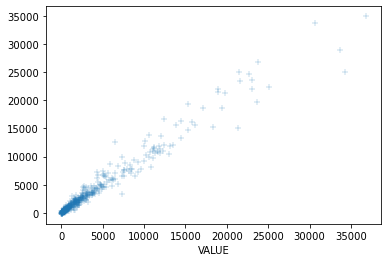

In [ ]:
sns.scatterplot(Y_test, Y_pred, marker="+", alpha=0.5)